# In this notebook we will add the final features we decided that can be worthy to help our predictions



## ✅ Current Feature Set Summary (with Explanations)

| 🏷️ Feature            | 🧠 Meaning                                        | 📈 Why It Helps                                              | ⚠️ Notes / Considerations                           |
| ---------------------- | ------------------------------------------------- | ------------------------------------------------------------ | --------------------------------------------------- |
| **roc\_4h**            | 4-hour rate of change (short-term momentum)       | Detects quick market moves and intraday trend shifts         | ⚠️ Moderately correlated with `ret_over_atr`        |
| **roc\_24h**           | 24-hour rate of change (daily momentum)           | Captures daily directional trends                            | ⚠️ Highly correlated with `price_above_ma50`        |
| **roc\_7days**         | 7-day rate of change (weekly momentum)            | Filters out noise and focuses on long-term bias              | ✅ Keep — unique signal                              |
| **body**               | Candle body (close - open)                        | Measures pressure magnitude from buyers/sellers              | ✅ Keep — low redundancy                             |
| **upper\_shadow**      | Wick from max(open, close) to high                | Suggests price rejection from above                          | ✅ Useful for candle psychology                      |
| **lower\_shadow**      | Wick from low to min(open, close)                 | Suggests support or rejection of lower prices                | ✅ Adds context to reversals                         |
| **boll\_b**            | Position inside Bollinger Bands (0=bottom, 1=top) | Locates price in volatility envelope                         | ⚠️ Overlaps with `roc_4h`, `band_width` slightly    |
| **vol\_ratio\_24h**    | Volume / average volume (24h)                     | Detects volume spikes → potential breakouts                  | ✅ High signal, low correlation                      |
| **ret\_over\_atr**     | Normalized momentum: `roc_4h / atr_14`            | Scales momentum by recent volatility                         | ⚠️ Some correlation with `roc_4h`                   |
| **band\_width**        | Bollinger Band width                              | Measures contraction/expansion — signals incoming volatility | ✅ Valuable volatility indicator                     |
| **tr**                 | True Range (max of high-low, prev close)          | Captures daily range while accounting for gaps               | ⚠️ Feeds into `atr_14`, but still useful            |
| **atr\_14**            | 14-period exponential average of True Range       | Smooth measure of recent volatility                          | ✅ Keep — industry standard                          |
| **price\_above\_ma50** | Ratio: close / SMA-50                             | Long-term trend strength signal                              | ⚠️ Highly correlated with `roc_24h` — may drop one  |
| **macd\_signal**       | 9-period EMA of MACD line                         | Identifies buy/sell signals via smoothing                    | ✅ Best MACD-derived feature                         |
| **macd\_diff**         | MACD line - signal line                           | Measures MACD momentum change — helps confirm crossovers     | ✅ Lower correlation — keep                          |
| **macd\_line**         | EMA12 - EMA26 difference                          | Raw MACD line before signal smoothing                        | ❌ High correlation (0.95) with `macd_signal` — drop |
| **open**               | Opening price                                     | Redundant with `close` and shadow calculations               | ❌ Drop for RF/XGB; keep only if LSTM                |
| **high**               | Highest candle price                              | Used for TR and upper shadow                                 | ❌ Drop for RF/XGB                                   |
| **low**                | Lowest candle price                               | Used for TR and lower shadow                                 | ❌ Drop for RF/XGB                                   |
| **close**              | Closing price                                     | Anchor for most technical indicators                         | ✅ Must keep                                         |

---

### 🔁 Model-specific ideas:

| Model            | Drop                               | Notes                                                          |
| ---------------- | ---------------------------------- | -------------------------------------------------------------- |
| **XGBoost**      | `open`, `high`, `low`, `macd_line` | Avoid redundancy; tree models handle small feature sets better |
| **RandomForest** | Same as XGBoost                    | Same logic applies — eliminate multicollinearity               |
| **LSTM**         | Maybe keep `open`, `high`, `low`   | Because it works with temporal sequences like OHLC             |

---


# Final

In [9]:
# ─────────────────────────── Paths & imports ────────────────────────────────
from pathlib import Path
import pandas as pd
import numpy as np

# Load original file
SRC = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
           r"\Stock-Market-Prediction\data\processed"
           r"\gemini_btc_data_final_version.csv")
df = pd.read_csv(SRC)
df["date"] = pd.to_datetime(df["date"])  # ensure datetime column

# ─────────────────────────── CONFIG: choose year to save ───────────────────
SAVE_YEAR = 2022  # ← change to which save years ud like

# ─────────── Bollinger band base components (no leakage) ───────────
mid = df["close"].rolling(window=20, min_periods=20).mean().shift(1)
std = df["close"].rolling(window=20, min_periods=20).std().shift(1)
lower = mid - 2 * std
upper = mid + 2 * std

# ─────────── MACD Features (leak-free) ───────────
ema_12 = df["close"].ewm(span=12, adjust=False).mean()
ema_26 = df["close"].ewm(span=26, adjust=False).mean()
df["macd_line"] = (ema_12 - ema_26).shift(1)  # lagged to t-1
df["macd_signal"] = df["macd_line"].ewm(span=9, adjust=False).mean()
df["macd_diff"] = df["macd_line"] - df["macd_signal"]


# ─────────── Candlestick anatomy (leak-free) ───────────
df["body"]         = (df["close"] - df["open"]).shift(1)
df["upper_shadow"] = (df["high"]  - df[["close", "open"]].max(axis=1)).shift(1)
df["lower_shadow"] = (df[["close", "open"]].min(axis=1) - df["low"]).shift(1)

# ─────────── Momentum Features ───────────
df["roc_4h"]    = df["close"].pct_change(4).shift(1)
df["roc_24h"]   = df["close"].pct_change(24).shift(1)
df["roc_7days"] = df["close"].pct_change(24 * 7).shift(1)

# ─────────── Volume spike detector ───────────
vol_mean_24h = df["Volume BTC"].rolling(window=24, min_periods=1).mean().shift(1)
df["vol_ratio_24h"] = df["Volume BTC"] / vol_mean_24h  # EOD = safe

# ─────────── Bollinger-band derived metrics ───────────
df["boll_b"]      = ((df["close"] - lower) / (upper - lower)).clip(0, 1)
df["band_width"]  = (upper - lower) / mid

# ─────────── True Range & ATR-14 (now leak-free) ───────────
df["tr"] = np.maximum.reduce([
    df["high"] - df["low"],
    (df["high"] - df["close"].shift()).abs(),
    (df["low"]  - df["close"].shift()).abs()
])
df["atr_14"] = df["tr"].ewm(span=14, adjust=False).mean().shift(1)

# ─────────── Return Normalized by ATR ───────────
df["ret_over_atr"] = df["roc_4h"] / df["atr_14"]

# ─────────── NEW FEATURE: Price vs. MA50 ───────────
ma_50 = df["close"].rolling(window=50, min_periods=50).mean().shift(1)
df["price_above_ma50"] = df["close"] / ma_50

# ─────────── Output directory setup ───────────
OUTDIR = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
              r"\Stock-Market-Prediction\data\processed")



# ─────────── Filter + Save ───────────
if SAVE_YEAR not in [2016,2017,2018,2019,2020,2021,2022]:
    raise ValueError("SAVE_YEAR isnt valid")

df_filtered = df[df["date"] >= f"{SAVE_YEAR}-01-01"].reset_index(drop=True)
#remove NANS
df_filtered.dropna(inplace=True)
filename = f"gemini_btc_data_final_version_with_features_{SAVE_YEAR}_final.csv"
df_filtered.to_csv(OUTDIR / filename, index=False)

print(f"✅ Saved successfully: {filename}")


✅ Saved successfully: gemini_btc_data_final_version_with_features_2022_final.csv


# Corelation check

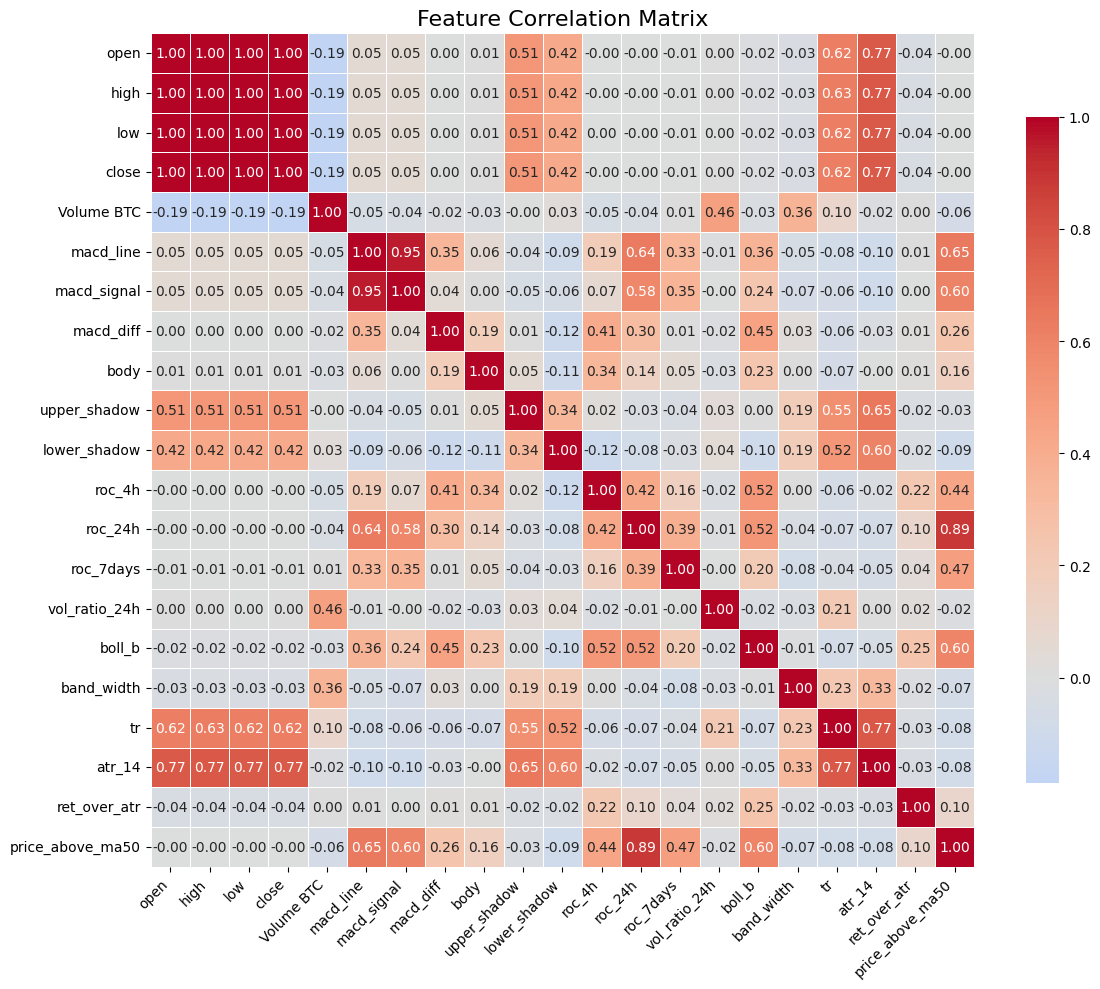

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ───────────── Load the file ─────────────
path = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2016_final.csv"
df = pd.read_csv(path)

# ───────────── Optional: remove non-numeric columns ─────────────
df_numeric = df.select_dtypes(include=['number'])

# ───────────── Compute correlation matrix ─────────────
corr_matrix = df_numeric.corr()

# ───────────── Plot heatmap ─────────────
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# Set file path
file_path = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2016_final.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_df.corr().round(2)

# Print the correlation matrix in a readable format
print("🔍 Correlation Matrix (Pearson):")
print(corr_matrix.to_string())


🔍 Correlation Matrix (Pearson):
                  open  high   low  close  Volume BTC  macd_line  macd_signal  macd_diff  body  upper_shadow  lower_shadow  roc_4h  roc_24h  roc_7days  vol_ratio_24h  boll_b  band_width    tr  atr_14  ret_over_atr  price_above_ma50
open              1.00  1.00  1.00   1.00       -0.19       0.05         0.05       0.00  0.01          0.51          0.42   -0.00    -0.00      -0.01           0.00   -0.02       -0.03  0.62    0.77         -0.04             -0.00
high              1.00  1.00  1.00   1.00       -0.19       0.05         0.05       0.00  0.01          0.51          0.42   -0.00    -0.00      -0.01           0.00   -0.02       -0.03  0.63    0.77         -0.04             -0.00
low               1.00  1.00  1.00   1.00       -0.19       0.05         0.05       0.00  0.01          0.51          0.42    0.00    -0.00      -0.01           0.00   -0.02       -0.03  0.62    0.77         -0.04             -0.00
close             1.00  1.00  1.00   1.0

Below is a concise review of the four pairs you listed **plus three high-leverage pairs that were missed**. I’ve kept the same layout and added an “✅ / ⚠️ / ❌” verdict for clarity.

| Feature A    | Feature B              | ρ (Pearson) | Why it’s high                                                                             | Verdict & Action                                                                                                                                                          |
| ------------ | ---------------------- | ----------- | ----------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **open**     | **high / low / close** | ≈ 1.00      | Derived from the same candlestick; no incremental signal once you retain one price level. | **✅ Drop** `open`, `high`, `low`; **keep** `close` (or compute a single “mid” price).                                                                                     |
| **roc\_24h** | **price\_above\_ma50** | 0.89        | Both encode medium-term trend direction.                                                  | **✅ Keep only one** – favour `price_above_ma50` (already smoothed & interpretable).                                                                                       |
| **roc\_4h**  | **ret\_over\_atr**     | 0.64        | `ret_over_atr` == `roc_4h / ATR`; adds a volatility-adjusted flavour.                     | **⚠️ Keep both for tree/NN models** (they exploit non-linear combos). **❌ Drop one in linear/logistic models** to control multicollinearity; usually keep `ret_over_atr`. |
| **close**    | **atr\_14**            | 0.73        | Sustained up-moves widen ATR. Correlation stems from trend, not construction.             | **⚠️ Accept** – they measure different concepts (level vs. volatility). No action.                                                                                        |

### Pairs that were overlooked

| Feature A      | Feature B              | ρ               | Why it matters                                                        | Suggested Solution                                                                                                 |
| -------------- | ---------------------- | --------------- | --------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **tr**         | **atr\_14**            | 0.75            | ATR is a 14-period mean of TR, so information is duplicated.          | **✅ Keep only `atr_14`** (smoother) **OR** keep `tr` if you want raw, fast-moving range; not both.                 |
| **Volume BTC** | **vol\_ratio\_24h**    | 0.51 (moderate) | Ratio normalises volume; raw size rarely helps once ratio is present. | **✅ Drop** `Volume BTC`, **keep** `vol_ratio_24h`.                                                                 |
| **boll\_b**    | **roc\_4h / roc\_24h** | ≈ 0.53–0.55     | Bollinger %b rises with positive returns; partial redundancy.         | If you keep `%b`, you can **❌ drop one return feature** (usually `roc_24h`). Otherwise keep returns and drop `%b`. |

### Updated quick-start feature set

```
close, body, upper_shadow, lower_shadow,
roc_4h, ret_over_atr, price_above_ma50,   # keep ONE of roc_4h vs ret_over_atr vs price_above_ma50
vol_ratio_24h,
atr_14,                                   # or tr (pick one)
boll_b                                    # optional: drop if using both roc_4h & roc_24h
```

That leaves **8–10 low-redundancy features**—a solid base for Random Forest/XGBoost and easy to expand with lags or interactions later.
